# 1. Import

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm
from datetime import datetime

# 2. Load Data

In [12]:
# load daily industry returns
df_daily = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios_Daily.CSV", index_col = 0)
df_daily.index = pd.to_datetime(df_daily.index, format = "%Y%m%d")
df_daily = df_daily / 100

# handle NA values
mask = (df_daily <= -0.99)
df_daily[mask] = np.nan

In [13]:
# load Fama French 3 Daily Factors
ff = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors_daily.CSV", index_col = 0)
ff.index = pd.to_datetime(ff.index, format = "%Y%m%d")
ff = ff / 100

# load Fama French 3 Monthly Factors
ff_monthly = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff_monthly.index = pd.to_datetime(ff_monthly.index, format = "%Y%m")
ff_monthly = ff_monthly / 100


# load 4 Monthly Fama French Factors (Mkt-RF, SMB, HML, MOM) and construct FF4 model
ff4 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff4.index = pd.to_datetime(ff4.index, format = "%Y%m")
ff4 = ff4 / 100

ff4_mom = pd.read_csv(str(Path().absolute()) + "/data/F-F_Momentum_Factor.CSV", index_col = 0)
ff4_mom.index = pd.to_datetime(ff4_mom.index, format = "%Y%m")
ff4_mom = ff4_mom / 100
ff4 = pd.concat([ff4, ff4_mom], axis = 1)
ff4 = ff4.dropna()


# load Fama French 5 Daily Factors
ff5 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_5_Factors_2x3.csv", index_col = 0)
ff5.index = pd.to_datetime(ff5.index, format = "%Y%m")
ff5 = ff5 / 100

In [14]:
# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100
print(df.index[0])

# remove NAs
mask = (df <= -0.99)
df[mask] = np.nan

# nb of industries dataframe
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")
mask = (nb_industries <= -0.99)
nb_industries[mask] = np.nan
print(nb_industries.index[0])
# average sizes dataframe
avg_size = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")
mask = (avg_size <= -0.99)
avg_size[mask] = np.nan
print(avg_size.index[0])

# sum of BE / sum of ME dataframe
be_over_me = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 4959, nrows = 99, header=0)
be_over_me.index = pd.to_datetime(be_over_me.index, format = "%Y")
print(be_over_me.index[0])

1926-07-01 00:00:00
1926-07-01 00:00:00
1926-07-01 00:00:00
1926-01-01 00:00:00


# 3. Calculate Characteristics

## 3.1 Market Cap, Book-to-Market, Momentum

In [15]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# momentum with monthly data
momentum = df.rolling(12).mean()

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").ffill()

# need to add missing portion of 2024 since data with shifted index is missing it
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)
mask = (be_over_me <= -99.99)
be_over_me[mask] = np.nan

print(mkt_cap.index[0])
print(momentum.index[0])
print(be_over_me.index[0])
print(df.index[0])

print(mkt_cap.shape)
print(momentum.shape)
print(be_over_me.shape)
print(df.shape)

1926-07-01 00:00:00
1926-07-01 00:00:00
1926-07-01 00:00:00
1926-07-01 00:00:00
(1182, 48)
(1182, 48)
(1182, 48)
(1182, 48)


## 3.2 Beta

In [16]:
indices = pd.date_range("1926-07-30", "2024-12-31", freq = "M")
betas = pd.DataFrame(index=indices, columns=df_daily.columns)

for industry, industry_timeseries in tqdm(df_daily.items()):
    # skip first 12 months since we need a 12 month lookback window
    for i in range(12, len(indices)):
        
        # start and end date
        # this ensures ranges of following form for example: Sep 1 to Aug 31 
        start = indices[i-12] + pd.Timedelta(days = 1)
        end = indices[i]
        
        X = ff.loc[start:end,["Mkt-RF"]]
        y = industry_timeseries.loc[start:end] - ff.loc[start:end, "RF"]
        
        X = sm.add_constant(X)
        model = sm.OLS(y, X, missing='none').fit()
        beta = model.params["Mkt-RF"]
        betas.loc[end, industry] = beta
    
# convert the indices from month ends to starts of months
betas = betas.resample("MS").last()

C:\Users\alebr\AppData\Local\Temp\ipykernel_17764\2985543327.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  indices = pd.date_range("1926-07-30", "2024-12-31", freq = "M")
0it [00:00, ?it/s]

48it [01:13,  1.53s/it]


## 3.3 Idiosyncratic Risk

In [17]:
# Get unique year-month pairs
monthly_periods = df_daily.resample('MS').mean().index

risk = pd.DataFrame(index=monthly_periods, columns=df_daily.columns)

for date in tqdm(monthly_periods):
    # Filter data for the entire month
    mask = (df_daily.index.year == date.year) & (df_daily.index.month == date.month)
    ret_data = df_daily[mask]
    factors_data = ff[mask]
    
    for industry, industry_timeseries in ret_data.items():
            
            # Ensure aligned data
            aligned_data = pd.concat([industry_timeseries, factors_data], axis = 1)
            
            X = aligned_data.loc[:,["Mkt-RF", "SMB", "HML"]].values
            y = (aligned_data.loc[:, industry] - aligned_data.loc[:, "RF"]).values
            
            X = sm.add_constant(X)
            model = sm.OLS(y, X, missing='none').fit()

            risk.loc[date, industry] = np.sqrt(model.mse_resid)
            

100%|██████████| 1182/1182 [00:49<00:00, 23.78it/s]


## 3.4 Long-Short Portfolios

In [18]:
def position(df: pd.DataFrame, n_assets: int):
    """
    Ranks assets by given characteristic and then determines the top n_assets and bottom n_assets to create long short portfolio
    ---
    :param df: dataframe of characteristics
    :param n_assets: number of assets to long and to short 
    :return: pandas DataFrame of positions of the long-short portfolio at each timestep
    """

    # in the case of ties, we need to arbitrarily pick an asset
    # otherwise, due to the way the "rank" function is written, we'd pick 4 instead of 5 assets 
    ranks = df.rank(ascending = False, method = "first", axis = 1)
    df_pos = pd.DataFrame(0, index = ranks.index, columns = ranks.columns)

    # longs
    df_pos[ranks <= n_assets] = 1

    # shorts
    # due to NAs, we can't simply pick assets from 48 to 48 - n_assets
    # we find the last rank and then pick the 5 ranks right below it
    threshold = (ranks.max(axis = 1) - n_assets)
    mask = ranks.gt(threshold, axis = 0)
    df_pos[mask] = -1

    return df_pos

In [19]:
def equal_weight_rets(df: pd.DataFrame, position: pd.DataFrame, n_longs: int):
    """
    calculates the returns of the equal weight long short portfolio 
    ---
    :param df: dataframe of underlying asset returns
    :param position: dataframe of positions at each timestep (usually the output of the position function)
    :param n_longs: number of long assets in the long-short portfolio
    :return: pandas DataFrame of returns of the equal-weighted long-short portfolio
    """
    
    # shift returns to account for lookahead bias
    performance = ((df * position.shift(1)) / n_longs).sum(axis = 1)
    return performance


def value_weights_rets(df, position, mkt_cap):
    """
    calculates the returns of the value weighted long short portfolio 
    ---
    :param df: dataframe of underlying asset returns
    :param position: dataframe of positions at each timestep (usually the output of the position function)
    :param mkt_cap: market cap of each industry in the universe
    :return: pandas DataFrame of returns of the value-weighted long-short portfolio
    """
    # long and short market weighted weights
    long_weights = mkt_cap[position == 1].div(mkt_cap[position == 1].sum(axis = 1), axis = 0)
    short_weights = mkt_cap[position == -1].div(mkt_cap[position == -1].sum(axis = 1), axis = 0)
    
    # returns of long-short portfolio
    # shift returns to account for lookahead bias
    long_portfolio = (df * long_weights.shift(1)).fillna(0)
    short_portfolio = (df * short_weights.shift(1)).fillna(0)
    performance = (long_portfolio - short_portfolio).sum(axis = 1)
    
    return performance

In [20]:
# long-short portfolio positions
pos_mkt_cap = position(mkt_cap, 5)
pos_be_over_me = position(be_over_me, 5)
pos_mom = position(momentum, 5)
pos_betas = position(betas, 5)
pos_risks = position(risk, 5)

# 4. Annualized Performance Measures

In [21]:
def mean_return(rets: pd.DataFrame):
    """
    calculates the annualized mean return of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :return: float of the annualized mean return
    """
    avg_ret = 12 * rets.mean()

    return avg_ret


def sharpe_ratio(rets: pd.DataFrame, rf: pd.DataFrame):
    """
    calculates the annualized sharpe ratio of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param rf: pandas Series/DataFrame of risk-free rate
    :return: float of the annualized sharpe ratio
    """

    sharpe = np.sqrt(12) * (rets - rf).mean() / rets.std()  # use excess returns
    return sharpe


def alpha(rets: pd.DataFrame, ff: pd.DataFrame):
    """
    calculates the annualized Jensen's Alpha by OLS regression of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param ff: pandas DataFrame of Fama French factors
    :return: float of the annualized alpha of the strategy
    """

    ff = ff.values
    ff = sm.add_constant(ff)
    model = sm.OLS(rets, ff, missing='none').fit()

    return 12 * model.params["const"]

def alpha_p_val(rets: pd.DataFrame, ff: pd.DataFrame):
    """
    calculates the p value of Jensen's Alpha obtained by OLS regression of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param ff: pandas DataFrame of Fama French factors
    :return: float of the p value of the alpha obtained
    """

    ff = ff.values
    ff = sm.add_constant(ff)
    model = sm.OLS(rets, ff, missing='none').fit()

    return model.pvalues["const"]

In [22]:
# equal weight returns
rets_mkt = equal_weight_rets(df, pos_mkt_cap, 5)
rets_be_me = equal_weight_rets(df, pos_be_over_me, 5)
rets_mom = equal_weight_rets(df, pos_mom, 5)
rets_betas = equal_weight_rets(df, pos_betas, 5)
rets_risks = equal_weight_rets(df, pos_risks, 5)

equal_weight_results = pd.DataFrame({"EW_Mkt": rets_mkt, 
                                     "EW_BE_ME": rets_be_me, 
                                     "EW_Momentum": rets_mom, 
                                     "EW_Beta": rets_betas, 
                                     "EW_Risks": rets_risks}, 
                                     index = rets_mkt.index)

# value weighted returns
rets_mkt = value_weights_rets(df, pos_mkt_cap, mkt_cap)
rets_be_me = value_weights_rets(df, pos_be_over_me, mkt_cap)
rets_mom = value_weights_rets(df, pos_mom, mkt_cap)
rets_betas = value_weights_rets(df, pos_betas, mkt_cap)
rets_risks = value_weights_rets(df, pos_risks, mkt_cap)

value_weights_results = pd.DataFrame({"Val_Mkt": rets_mkt, 
                                      "Val_BE_ME": rets_be_me, 
                                      "Val_Momentum": rets_mom, 
                                      "Val_Beta": rets_betas, 
                                      "Val_Risks": rets_risks}, 
                                      index = rets_mkt.index)

portfolio_results = pd.concat([equal_weight_results, value_weights_results], axis = 1)

In [23]:
start_date = [datetime(year = 1950, month = 1, day = 1), datetime(year = 1990, month = 1, day = 1), datetime(year = 2000, month = 1, day = 1)]
results = [np.nan, np.nan, np.nan]

for i in range(len(start_date)):
    
    start = start_date[i]
    # select current period for returns
    mask = portfolio_results.index >= start
    current_portfolio = portfolio_results[mask]
    
    # select current period for alpha
    current_ff3 = ff_monthly.loc[ff_monthly.index >= start, ["Mkt-RF", "SMB", "HML", "RF"]]
    current_ff4 = ff4.loc[ff4.index >= start, ["Mkt-RF", "SMB", "HML", "Mom   ", "RF"]]
    current_ff5 = ff5.loc[(ff5.index >= max(start, datetime(1963, 7, 1))), ["Mkt-RF", "SMB", "RMW", "CMA", "RF"]]
    
    mean_rets= current_portfolio.apply(mean_return, axis = 0)
    sharpe_ratios = current_portfolio.apply(lambda x: sharpe_ratio(x, ff_monthly["RF"]), axis = 0)

    alpha_ff3 = current_portfolio.apply(lambda x: alpha(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)
    p_vals_ff3 = current_portfolio.apply(lambda x: alpha_p_val(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)

    alpha_ff4 = current_portfolio.apply(lambda x: alpha(x - current_ff4["RF"], current_ff4[["Mkt-RF", "SMB", "HML", "Mom   "]]), axis = 0)
    p_vals_ff4 = current_portfolio.apply(lambda x: alpha_p_val(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)
    
    alpha_ff5 = current_portfolio.loc[(current_portfolio.index >= datetime(1963, 7, 1))].apply(lambda x: alpha(x - current_ff5["RF"], current_ff5[["Mkt-RF", "SMB", "RMW", "CMA"]]), axis = 0)
    p_vals_ff5 = current_portfolio.apply(lambda x: alpha_p_val(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)

    results[i] = pd.concat([mean_rets, sharpe_ratios, alpha_ff3, p_vals_ff3, alpha_ff4, p_vals_ff4, alpha_ff5, p_vals_ff5], axis = 1)
    results[i].columns = ["Mean Return", "Sharpe Ratio", "Alpha 3 Factor Fama French", "P-Value of Alpha 3 Factor Fama French", "Alpha 4 Factor Fama French", "P-Value of Alpha 4 Factor Fama French", "Alpha 5 Factor Fama French", "P-Value of Alpha 5 Factor Fama French"]
    

In [24]:
results[0]

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,P-Value of Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,P-Value of Alpha 4 Factor Fama French,Alpha 5 Factor Fama French,P-Value of Alpha 5 Factor Fama French
EW_Mkt,-0.023079,-0.395685,-0.025994,8.475204e-02,-0.040053,8.475204e-02,0.007488,8.475204e-02
EW_BE_ME,0.012385,-0.174801,-0.076634,3.273917e-08,-0.047914,3.273917e-08,-0.079772,3.273917e-08
EW_Momentum,0.122508,0.429112,0.106120,2.681076e-06,-0.006822,2.681076e-06,0.096076,2.681076e-06
EW_Beta,0.017491,-0.112195,-0.068015,2.362203e-04,-0.051282,2.362203e-04,-0.019285,2.362203e-04
EW_Risks,-0.014734,-0.380066,-0.069894,1.725715e-05,-0.062725,1.725715e-05,-0.074056,1.725715e-05
Val_Mkt,-0.030365,-0.462922,-0.037443,1.043314e-02,-0.052795,1.043314e-02,-0.003041,1.043314e-02
Val_BE_ME,0.004470,-0.213566,-0.086037,8.386623e-11,-0.062202,8.386623e-11,-0.094204,8.386623e-11
Val_Momentum,0.111014,0.345950,0.091736,1.514365e-04,-0.034782,1.514365e-04,0.057277,1.514365e-04
Val_Beta,0.020016,-0.094058,-0.063680,9.162425e-04,-0.051655,9.162425e-04,-0.015180,9.162425e-04
Val_Risks,-0.008531,-0.277208,-0.067911,5.843030e-04,-0.052885,5.843030e-04,-0.066096,5.843030e-04


<Figure size 1200x600 with 0 Axes>

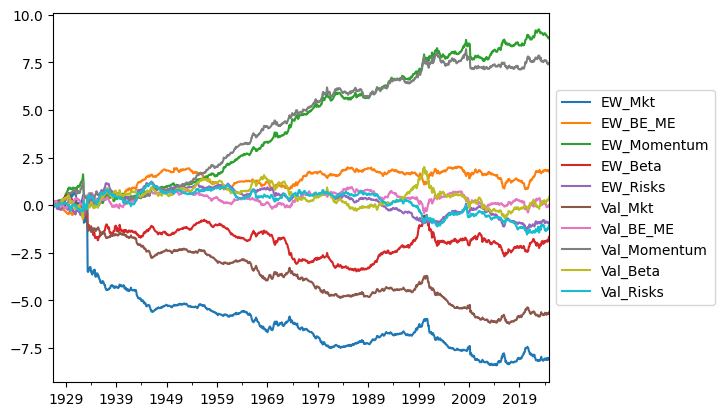

In [25]:
# Resize the plot
plt.figure(figsize=(12, 6))  # Adjust the figure size (width, height)

# Plot the data
np.log((1 + portfolio_results).cumprod()).plot()

# Relocate the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust legend position

# Show the plot
plt.show()

In [26]:
portfolio_results.loc["1932", "EW_Mkt"]

1932-01-01   -0.03680
1932-02-01    0.04914
1932-03-01   -0.01014
1932-04-01    0.11094
1932-05-01    0.10890
1932-06-01    0.13438
1932-07-01   -0.09414
1932-08-01   -0.73900
1932-09-01    0.05404
1932-10-01    0.02662
1932-11-01   -0.01270
1932-12-01    0.20030
Name: EW_Mkt, dtype: float64

In [27]:
# 1950 + (except for FF5 it is 1964 +)
results[0]

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,P-Value of Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,P-Value of Alpha 4 Factor Fama French,Alpha 5 Factor Fama French,P-Value of Alpha 5 Factor Fama French
EW_Mkt,-0.023079,-0.395685,-0.025994,8.475204e-02,-0.040053,8.475204e-02,0.007488,8.475204e-02
EW_BE_ME,0.012385,-0.174801,-0.076634,3.273917e-08,-0.047914,3.273917e-08,-0.079772,3.273917e-08
EW_Momentum,0.122508,0.429112,0.106120,2.681076e-06,-0.006822,2.681076e-06,0.096076,2.681076e-06
EW_Beta,0.017491,-0.112195,-0.068015,2.362203e-04,-0.051282,2.362203e-04,-0.019285,2.362203e-04
EW_Risks,-0.014734,-0.380066,-0.069894,1.725715e-05,-0.062725,1.725715e-05,-0.074056,1.725715e-05
Val_Mkt,-0.030365,-0.462922,-0.037443,1.043314e-02,-0.052795,1.043314e-02,-0.003041,1.043314e-02
Val_BE_ME,0.004470,-0.213566,-0.086037,8.386623e-11,-0.062202,8.386623e-11,-0.094204,8.386623e-11
Val_Momentum,0.111014,0.345950,0.091736,1.514365e-04,-0.034782,1.514365e-04,0.057277,1.514365e-04
Val_Beta,0.020016,-0.094058,-0.063680,9.162425e-04,-0.051655,9.162425e-04,-0.015180,9.162425e-04
Val_Risks,-0.008531,-0.277208,-0.067911,5.843030e-04,-0.052885,5.843030e-04,-0.066096,5.843030e-04


In [28]:
results[1] # 1990 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,P-Value of Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,P-Value of Alpha 4 Factor Fama French,Alpha 5 Factor Fama French,P-Value of Alpha 5 Factor Fama French
EW_Mkt,-0.011360,-0.208859,-0.015271,0.545750,-0.031801,0.545750,0.037242,0.545750
EW_BE_ME,0.013098,-0.075632,-0.048499,0.035561,-0.024317,0.035561,-0.078853,0.035561
EW_Momentum,0.108601,0.364801,0.111472,0.003234,0.017662,0.003234,0.115632,0.003234
EW_Beta,0.069688,0.181456,-0.029467,0.344295,-0.010366,0.344295,0.025870,0.344295
EW_Risks,-0.020981,-0.287859,-0.057978,0.038682,-0.048112,0.038682,-0.062123,0.038682
Val_Mkt,-0.016071,-0.255606,-0.025412,0.282415,-0.041948,0.282415,0.025582,0.282415
Val_BE_ME,-0.002386,-0.148436,-0.059186,0.008066,-0.036788,0.008066,-0.091864,0.008066
Val_Momentum,0.072420,0.190252,0.073077,0.072312,-0.031865,0.072312,0.071016,0.072312
Val_Beta,0.043993,0.071431,-0.053024,0.094538,-0.033612,0.094538,0.007742,0.094538
Val_Risks,-0.023816,-0.244149,-0.071881,0.039268,-0.047544,0.039268,-0.071734,0.039268


In [29]:
results[2] # 2000 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,P-Value of Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,P-Value of Alpha 4 Factor Fama French,Alpha 5 Factor Fama French,P-Value of Alpha 5 Factor Fama French
EW_Mkt,-0.056752,-0.379511,-0.043415,0.173343,-0.053717,0.173343,0.021987,0.173343
EW_BE_ME,0.039340,0.113388,-0.021447,0.463550,-0.005585,0.463550,-0.063988,0.463550
EW_Momentum,0.076601,0.242435,0.089030,0.060096,0.027727,0.060096,0.081615,0.060096
EW_Beta,-0.004102,-0.086422,-0.092178,0.010438,-0.074619,0.010438,-0.035024,0.010438
EW_Risks,0.016827,-0.004822,-0.015290,0.664012,-0.011508,0.664012,-0.023548,0.664012
Val_Mkt,-0.053932,-0.401800,-0.048204,0.100002,-0.058469,0.100002,0.015051,0.100002
Val_BE_ME,0.029954,0.059333,-0.031641,0.260944,-0.017237,0.260944,-0.073285,0.260944
Val_Momentum,0.030457,0.049338,0.041224,0.416057,-0.026273,0.416057,0.028290,0.416057
Val_Beta,-0.025539,-0.168694,-0.106523,0.006197,-0.089227,0.006197,-0.037600,0.006197
Val_Risks,0.018484,0.003663,-0.023766,0.580942,-0.012228,0.580942,-0.021228,0.580942


# Testing

In [34]:
def long_short_portfolio_char(df, mkt_cap, characteristic):
    """
    Calculates the returns of a long-short portfolio where the 5 highest characteristic companies are bought
    and the 5 lowest characteristic companies are sold, with allocations based on market weights and equal weight.
    ---
    :param df: DataFrame of underlying industry returns
    :param mkt_cap: DataFrame of market cap of each company
    :param characteristic: DataFrame of characteristic values of each industry
    :return: pandas Series of returns of the long-short portfolio
    """

    results = pd.DataFrame(index = characteristic.index[1:], columns = ["Market Cap", "Equal Weight"], dtype="float")

    for i in range(len(characteristic) - 1):
        # Get returns for the next period
        next_returns = df.iloc[i + 1].dropna()

        # Get characteristic values for the current period
        current_characteristic = characteristic.iloc[i][next_returns.index]
        # Sort companies by characteristic
        sorted_characteristic = current_characteristic.sort_values(ascending=False)
        
        # Select the 5 highest and 5 lowest book-to-market companies
        highest_char_ind = sorted_characteristic.dropna().head(5)
        lowest_char_ind = sorted_characteristic.dropna().tail(5)

        # Calculate market weights
        long_weights_mkt = mkt_cap.iloc[i][highest_char_ind.index] / mkt_cap.iloc[i][highest_char_ind.index].sum()
        short_weights_mkt = mkt_cap.iloc[i][lowest_char_ind.index] / mkt_cap.iloc[i][lowest_char_ind.index].sum()
        
        # Calculate equal weights
        equal_weights = np.full(5, 1/5)

        # if np.isnan(next_returns[highest_char_ind.index]).any():
        #     print(f'row: {i} there is a {next_returns[highest_char_ind.index]}')
        # elif np.isnan(next_returns[lowest_char_ind.index]).any():
        #     print(f'row: {i} there is a {next_returns[lowest_char_ind.index]}')

        # handle case where all values are NaN

        if (highest_char_ind.index.empty or lowest_char_ind.index.empty):
            results.iloc[i, 0] = np.nan
            results.iloc[i, 1] = np.nan
        else:
            # Calculate value-weighted portfolio return
            long_return = next_returns[highest_char_ind.index] @ long_weights_mkt
            short_return = next_returns[lowest_char_ind.index] @ short_weights_mkt
            portfolio_return_mkt = long_return - short_return

            # Calculate equal-weighted portfolio return
            long_return = next_returns[highest_char_ind.index] @ equal_weights
            short_return = next_returns[lowest_char_ind.index] @ equal_weights
            portfolio_return_eq = long_return - short_return

            results.iloc[i, 0] = portfolio_return_mkt
            results.iloc[i, 1] = portfolio_return_eq

        # if (i <= 5):
        #    print(current_characteristic)
        #    print(next_returns)
        #    print(results.iloc[i])

    print(np.isnan(results).sum())
    return results


portfolio_returns_btm = long_short_portfolio_char(df, mkt_cap, be_over_me)
portfolio_returns_mkt = long_short_portfolio_char(df, mkt_cap, mkt_cap)
portfolio_returns_mom = long_short_portfolio_char(df, mkt_cap, momentum)
portfolio_returns_betas = long_short_portfolio_char(df, mkt_cap, betas)
portfolio_returns_risks = long_short_portfolio_char(df, mkt_cap, risk)

Market Cap      0
Equal Weight    0
dtype: int64
Market Cap      0
Equal Weight    0
dtype: int64
Market Cap      11
Equal Weight    11
dtype: int64
Market Cap      12
Equal Weight    12
dtype: int64
Market Cap      0
Equal Weight    0
dtype: int64


<Axes: >

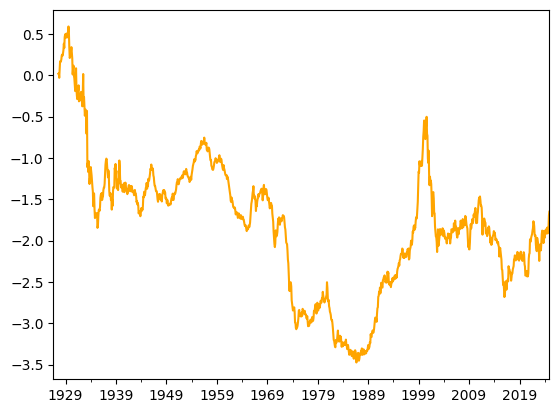

In [31]:
np.log((1 + portfolio_returns_betas["Equal Weight"]).cumprod()).plot(c = "orange")

<Axes: >

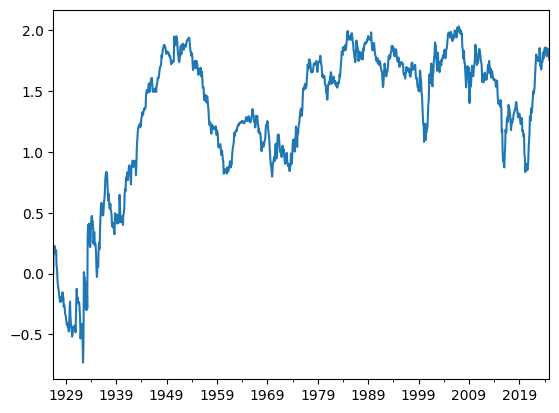

In [32]:
np.log((1 + portfolio_results["EW_BE_ME"]).cumprod()).plot()